In [58]:
import numpy as np
import random
from random import sample
import scipy as sp
from scipy.stats import qmc
import matplotlib.pyplot as plt
from typing import List 
from typing import Tuple
from matplotlib.axes import Axes

#### Problem 1: Impliment the iterations for Mandelbrot set and Create pictures of the Fractal

In [27]:
def is_mandelbrot (c: complex, max_iters: int) -> int :
    '''
    A function that checks if a number is inside the Mandelbrot set.

    Args:
    c - complex number
    max_iters - The maximum number of iterations to perform when testing if `c` is in the Mandelbrot set.

    Returns :
    max_recusion if the number is in the Mandelbrot Set otherwise returns
    the iteration at which the magnitude of the sequence escapes the threshold value
    '''
    counter = 0
    threshold = 2
    Z_now = complex(0,0)
    
    while(counter < max_iters):
        Z_next = pow (Z_now , 2) + c
        if(abs(Z_next) > threshold):
            return counter
        Z_now = Z_next
        counter+=1
    
    return max_iters

In [28]:
def point_counter(x: List[int], y: List[int], max_iters: int)-> int:
    '''
    A function to count the number of points inside the Mandelbrot set,
    which are coming from a sample pool.

    Args:
    x - coordinates of the point
    y - coordinates of the point
    max_iters - The maximum number of iterations to perform when testing if the complex number is in the Mandelbrot set.

    Returns:
    The number of points inside the Mandelbrot set 
    '''
    counter = 0

    for i, x_i in enumerate(x):
        c = complex(x_i,y[i])
        check = is_mandelbrot(c,max_iters)
        if check == max_iters : counter+= 1

    return counter

In [29]:
def create_grid(x: List[int], y: List[int], max_iters: int)-> np.ndarray:
    '''
    Function to create a grid of numbers based on how many iterations a point needs to escape the threshold values 
    Args:
    x - coordinates of the point
    y - coordinates of the point
    max_iters - The maximum number of iterations to perform when testing if the complex number is in the Mandelbrot set.
    '''
    
    X, Y = np.meshgrid(x,y)
    C = np.vectorize(complex)(X,Y)
    Z=[]

    for row in C:
        Z_row = []
        for c in row:
            Z_row.append(is_mandelbrot(c, max_iters))
        Z.append(Z_row)
    Z = np.array(Z)

    return Z

In [30]:
def plot_fractal(Z: np.ndarray, x1: float, x2: float, y1: float, y2: float):
    '''
    Function to plot the Fractal 
    Args:
    x1,x2 - bounds on the X-axis 
    y1,y2 - bounds on the Y-axis
    Z - grid of max_iters over all the points 
    '''
    plt.figure(figsize=(10,7))
    plt.imshow(Z, extent = (x1,x2,y1,y2), cmap='Blues_r', interpolation = 'bilinear')
    plt.colorbar(label = 'Recursions to escape')
    plt.title('Mandelbrot Set')
    plt.xlabel('Re(c)')
    plt.ylabel('Im(c)')
    plt.show()

In [37]:
# Defining the initial parameters 
max_iters = 100 # Maximum number of iterations to check for 
num_samples = 1000 # Sample size
x = np.linspace (-1.7, 0.7, num_samples)
y = np.linspace (-1.2, 1.2, num_samples)

In [ ]:
plot_fractal(create_grid(x, y, max_iters), min(x), max(x), min(y), max(y))

### Problem 2: Investigating the Convergence of $A_{i,s} \to A_{m}$

In [33]:
def get_area(x_range: List[float], y_range: List[float], x_samples: List[float], y_samples: List[float], max_iters: int, num_samples: int)-> float:
    '''
    Computes the area for give sample of points 
    Args:
    x_range - defines the bounds on the x axis 
    y_range - defines the bounds on the y axis 
    x_samples - x-coordinates of the sampled points 
    y_samples - y-coordinates of the sampled points 
    max_iters - The maximum number of iterations to perform when testing if the complex number is in the Mandelbrot set.

    '''
    
    mandelbrot_count = point_counter(x_samples, y_samples, max_iters) # Counting the number the points we sampled that lie inside the Mandelbrot Set 
    total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0]) # Total area enclosed inside the boundary we considered 
    estimated_area = total_area * mandelbrot_count / num_samples

    return estimated_area

In [62]:
def PR_area_estimate(x_range: List[float], y_range: List[float], max_iters: int, num_samples: int)-> Tuple[List[float],List[float],float]:
    '''
    Estimates area of Mandelbrot set using Pure Random Sampling

    Args:
    x_range - range of the x coordinates
    y_range - range of the y coordinates
    max_iters -  The maximum number of iterations to perform when testing if the complex number is in the Mandelbrot set.
    num_samples - number of samples to be taken
    '''
    #Sampling (x,y) for points in the complex plane C randomly 
    x_samples = np.random.uniform(x_range[0], x_range[1], num_samples)
    y_samples = np.random.uniform(y_range[0], y_range[1], num_samples)

    estimated_area = get_area(x_range,y_range,x_samples,y_samples,max_iters,num_samples)
    
    return x_samples, y_samples, estimated_area

In [41]:
def plot_errors(ax: Axes, n_list: List[int], data: List[float], y_label: str, title: str):
    
    for n in n_list:
        if y_label=='Iteration Error / Sampling Error':
            ax.plot(np.arange(1, max_iters), data[n], label=f'Sample size = {n}')
        else:
            ax.plot(np.arange(1, max_iters), data[n][:-1], label=f'Sample size = {n}')
    
    ax.set_xlabel('Number of Iterations')
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xticks([1, 10, 20, 50, 100, 200, 500])
    ax.set_xticklabels(['1', '10', '20', '50', '100','200','500'])
    ax.legend()
    ax.grid(True)

In [61]:
def error_analysis(x_range: Tuple[float,float], y_range: Tuple[float,float], max_iters: int, n_list: List[int], repetitions: List[int],col_idx: int,axes: Axes)-> Tuple[List[float], List[float], List[float]]:
    '''
    Error analysis with metrics and visualizations. Investigating
    the convergence of i and s.

    Args:
        x_range (tuple): (min_x, max_x) range for sampling
        y_range (tuple): (min_y, max_y) range for sampling
        max_iters (int): Maximum iterations of the number to test
        n_list (list): List of sample sizes to analyze
        repetitions (int): Number of times to repeat the MC
    '''

    iteration_errors = {}
    sampling_errors = {}
    # convergence_rates = {}
    error_ratios = {}

    for n in n_list:
        estimates = np.zeros((repetitions, max_iters))
        for rep in range(repetitions):
           
            x,y,_=PR_area_estimate(x_range, y_range, max_iters, n)
            area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

            for j in range(max_iters):
                count = 0
                for x_i, y_i in zip(x, y):
                    point = complex(x_i, y_i)
                    result = is_mandelbrot(point, j + 1)
                    if result == j + 1:
                        count += 1
                estimates[rep, j] = (count/n) * area

        fig = plt.figure(figsize=(15, 15))
        gs = fig.add_gridspec(3, 1, hspace=0.4)  

        iteration_errors[n] = np.abs(np.mean(estimates, axis=0) - np.mean(estimates[:, -1]))
        sampling_errors[n] = np.var(estimates, axis=0)

        epsilon = 1e-10 
        error_ratios[n] = iteration_errors[n][:-1] / (sampling_errors[n][:-1] + epsilon)

    ax1 = axes[0, col_idx]
    plot_errors(ax1, n_list, iteration_errors, y_label='Iteration Error', title=f'Iteration Error (max_iters={max_iters})')
    ax2 = axes[1, col_idx]
    plot_errors(ax2, n_list, sampling_errors, y_label='Sampling Error', title=f'Sampling Error (max_iters={max_iters})')
    ax3 = axes[2, col_idx]
    plot_errors(ax3, n_list, error_ratios, y_label='Iteration Error / Sampling Error', title=f'Error Ratio (max_iters={max_iters})')

    return iteration_errors, sampling_errors, error_ratios


In [ ]:
#usage
x_range = (-1.7, 0.7)
y_range = (-1.2, 1.2)
max_iters_list = [50, 100, 200, 500]
n_list = [100, 500, 1000, 10000]
num_simulations = 10


plt.figure(figsize=(20, 15))
# Create a 3x4 grid (3 rows for error types, 4 columns for different max_iters)
fig, axes = plt.subplots(3, len(max_iters_list), figsize=(20, 15))

# Run analysis for each max_iters
for idx, max_iters in enumerate(max_iters_list):
    print(f"\nAnalysis for max_iters = {max_iters}")
    iteration_errors, sampling_errors, error_ratios = error_analysis(x_range, y_range, max_iters, n_list, num_simulations, idx, axes)

    # Print analysis results
    print("Analysis Results:")
    print("================")
    for n in n_list:
        optimal_iter = np.argmin(np.abs(error_ratios[n] - 1)) + 1
        print(f"\nSample size n = {n}:")
        print(f"Optimal iterations: {optimal_iter}")
        print(f"At optimal point:")
        print(f"  Iteration error: {iteration_errors[n][optimal_iter-1]:.6f}")
        print(f"  Sampling error:  {sampling_errors[n][optimal_iter-1]:.6f}")
        print(f"  Error ratio:     {error_ratios[n][optimal_iter-1]:.3f}")

plt.tight_layout()
plt.show()

### Problem 3: Comparing results obtained via different methods of Sampling 

In [53]:
def LHS_area_estimate(x_range: List[float], y_range: List[float], max_iters: int, num_samples: int)-> float:
    '''
    Estimates area of Mandelbrot set using Latin Hypercube sampling method

    Args:
    x_range - range of the x coordinates
    y_range - range of the y coordinates
    max_recursion -  the number of times we want to observe the progression of the number
    num_samples - number of samples to be taken
    '''
    sample_set = qmc.LatinHypercube(d=2)
    sample = sample_set.random(n=num_samples)

    x_samples = x_range[0] + sample[:, 0] * (x_range[1] - x_range[0])
    y_samples = y_range[0] + sample[:, 1] * (y_range[1] - y_range[0])

    estimated_area = get_area(x_range,y_range,x_samples,y_samples,max_iters,num_samples)

    return estimated_area

In [52]:
def ortho_area_estimate(x_range, y_range, max_iters, num_samples, sub_sections)-> float:

    samples_per_section = num_samples // (sub_sections * sub_sections)

    x_size = np.linspace(x_range[0], x_range[1], sub_sections + 1)
    y_size = np.linspace(y_range[0], y_range[1], sub_sections + 1)

    x_samples = []
    y_samples = []

    for i in range(sub_sections):
        for j in range(sub_sections):

            # Latin hypercube for each sub section
            sample_set = qmc.LatinHypercube(d=2)
            cell_samples = sample_set.random(n=samples_per_section)

            # Min and max of y values
            x_cell_min, x_cell_max = x_size[i], x_size[i + 1]
            y_cell_min, y_cell_max = y_size[j], y_size[j + 1]

            # Scales samples to be between 0 and 1 for LHS
            x_cell_samples = x_cell_min + cell_samples[:, 0] * (x_cell_max - x_cell_min)
            y_cell_samples = y_cell_min + cell_samples[:, 1] * (y_cell_max - y_cell_min)

            # Adds scaled points to sample arrays
            x_samples.extend(x_cell_samples)
            y_samples.extend(y_cell_samples)

    x_samples = np.array(x_samples)
    y_samples = np.array(y_samples)

    estimated_area = get_area(x_range,y_range,x_samples,y_samples,max_iters,num_samples)

    return estimated_area

In [63]:
def run_multiple_simulations(x_range, y_range, max_iters, n, sample_type, num_simulations, sub_sections)-> Tuple[List[float],List[float]]:
    """
    Runs multiple simulations for the given max iterations, n samples, and type of sampling method.
    
    Args:
    x_range - range of the x coordinates
    y_range - range of the y coordinates
    max_recursion -  The maximum number of iterations to perform when testing if the complex number is in the Mandelbrot set.
    num_simulations - number of simulations to be run 
    sample_type - Variable to choose the type of sampling we need 


    Returns the average area estimate from the simulations.
    """
    areas = []

    for _ in range(num_simulations):
        if sample_type == "Pure Random":
            _,_,est_area = PR_area_estimate(x_range, y_range, max_iters, n)
        elif sample_type == "Latin Hypercube":
            est_area = LHS_area_estimate(x_range, y_range, max_iters, n)
        else:
            est_area = ortho_area_estimate(x_range, y_range, max_iters, n, sub_sections)

        areas.append(est_area)

    return np.mean(areas), np.std(areas)

In [55]:
def plot_areas_convergence(x_range: Tuple[float,float], y_rangex_range: Tuple[float,float], n_list: List[int], max_iters_range: List[int], num_simulations: int, sub_sections: int):
    """
    Plots the convergence of the area estimates with respect to increasing sample sizes and iterations.
    Runs multiple simulations for each combination of iterations and samples for three sampling types.
    x_range - range of the x coordinates
    y_range - range of the y coordinates
    max_recursion -  The maximum number of iterations to perform when testing if the complex number is in the Mandelbrot set.
    num_samples - number of samples to be taken
    """
    sampling_types = ["Pure Random", "Latin Hypercube", "Orthogonal"]
    area_results = {sample_type: {} for sample_type in sampling_types}
    print("Means and Errors of A(i,s):")

    # Run simulations for all sampling methods
    for sample_type in sampling_types:
        for max_iters in max_iters_range:
            areas = []
            area_diffs = []
            errors = []

            print(f"\nMax Iterations i = {max_iters}, Sampling Method = {sample_type}")

            for n in n_list:
                avg_area, st_dev = run_multiple_simulations(x_range, y_range, max_iters, n, sample_type, num_simulations, sub_sections)
                areas.append(avg_area)
                RMSE = st_dev / np.sqrt(num_simulations)
                errors.append(RMSE)

                print(f"  Sample Size (s = {n}): Mean A(i,s) = {avg_area:.4f}, RMSE = {RMSE:.4f}")

            final_area = areas[-1] # Last area/iteration combination, assumed to be optimal
            for area in areas[:-1]:
                diff = abs(area - final_area)
                area_diffs.append(diff)

            area_results[sample_type][max_iters] = (area_diffs, errors[:-1], areas)

    fig, axs = plt.subplots(3, 3, figsize=(18, 18))
    colors = plt.cm.viridis(np.linspace(0, 1, len(max_iters_range)))

    # Plot 1: Convergence (A(j,s) - A(i,s))
    for i, sample_type in enumerate(sampling_types):
        for j, (max_iters, (diffs, errs, _)) in enumerate(area_results[sample_type].items()):
            axs[0, i].errorbar(n_list[:-1], diffs, yerr=errs, label=f"Max Iter = {max_iters}", color=colors[j], capsize=3, marker='o', linestyle='-', linewidth=2)
        axs[0, i].set_title(f'Convergence of A(j,s) - A(i,s) ({sample_type})')
        axs[0, i].set_xlabel("Sample Size (s)")
        axs[0, i].set_ylabel("Difference A(j,s) - A(i,s)")
        axs[0, i].grid(True, which='both', linestyle='--', alpha=0.7)
        axs[0, i].legend(fontsize=10)

    # Plot 2: Stabilization of Area Estimates (A(i,s))
    for i, sample_type in enumerate(sampling_types):
        for j, (max_iters, (_, _, areas)) in enumerate(area_results[sample_type].items()):
            axs[1, i].plot(n_list, areas, label=f"Max Iter = {max_iters}", color=colors[j], marker='x', linestyle='-', linewidth=2)
        axs[1, i].set_title(f'Stabilization of Area Estimates A(i,s) ({sample_type})')
        axs[1, i].set_xlabel("Sample Size (s)")
        axs[1, i].set_ylabel("Area Estimate A(i,s)")
        axs[1, i].grid(True, which='both', linestyle='--', alpha=0.7)
        axs[1, i].legend(fontsize=10)

    # Plot 3: Stabilization of RMSE
    for i, sample_type in enumerate(sampling_types):
        for j, (max_iters, (_, errs, _)) in enumerate(area_results[sample_type].items()):
            axs[2, i].plot(n_list[:-1], errs, label=f"Max Iter = {max_iters}", color=colors[j], marker='s', linestyle='-', linewidth=2)
        axs[2, i].set_title(f'Stabilization of RMSE ({sample_type})')
        axs[2, i].set_xlabel("Sample Size (s)")
        axs[2, i].set_ylabel("RMSE")
        axs[2, i].grid(True, which='both', linestyle='--', alpha=0.7)
        axs[2, i].legend(fontsize=10)

    plt.tight_layout()
    plt.show()


In [ ]:
max_iters_range = [10, 50, 100, 500, 700, 1000]
n_list = [100, 500, 1000, 5000, 7000, 10000]
sub_sections = 5 # Number of subsections for orthogonal testing 

plot_areas_convergence(x_range, y_range, n_list, max_iters_range, num_simulations, sub_sections)

### Problem 4:  Formulating a method to improve the convergence rate of the Monte Carlo

In [67]:
def stratified_sampling_mandelbrot(x_range: List[float], y_range: List[float], max_iters: int = 1000  , n_strata: int = 10 , points_per_stratum:int = 100) -> float :
    '''
    Function to divide the complex space into strata sample a fixed number of points and then calculate the area of every strata individually
    Args:
    Inputs:
    max_iters(int) : Is the maximum number of iterations we need to run the recursive check for Mandelbrot Check
    n_strata(int) : Number of horizontal and vertical subdivisions in the domain of points we want to sample
    points_per_stratum (int) : As the name implies the number of points in a stratum
    Returns:
    total_area(float) : Estimate of the Mandelbrot Area
    '''
    
    #Dividing the comple space into stratum for sampling points
    x_strata = np.linspace(x_range[0], x_range[1], n_strata+1)
    y_strata = np.linspace(y_range[0], y_range[1], n_strata+1)

    total_area = 0

    for i in range(n_strata):
        for j in range(n_strata):
            # Define the bounds of the stratum
            x_bounds = (x_strata[i], x_strata[i+1])
            y_bounds = (y_strata[j], y_strata[j+1])

            # Sample points within the stratum
            x_samples = np.random.uniform(x_bounds[0], x_bounds[1], points_per_stratum)
            y_samples = np.random.uniform(y_bounds[0], y_bounds[1], points_per_stratum)

            stratum_mandelbrot_area =  get_area(x_bounds,y_bounds,x_samples,y_samples,max_iters,points_per_stratum)
            total_area += stratum_mandelbrot_area

    return total_area


In [68]:
def plot_converge(area: List[float], iters_list: List[int]):
    '''
    Function to plot the convergence of the Mandelbrot Set Area estimates 
    area(np.ndarray) : List of area estimates
    iters_list(np.ndarray) : List of iterations to go through 
    '''
    area = np.array(area)
    error_area = np.abs(area - area[-1])

    plt.figure(figsize=(12, 8))
    plt.plot(iters_list, error_area, marker='o', linestyle='-', linewidth=2, color='red', label='Error in Area Estimation')

    plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7, label='y = 0')

    plt.title("Convergence of Mandelbrot Set Area Estimation", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Iteration Number ($i$)", fontsize=14)
    plt.ylabel("$|A_{i,s} - A_{j,s}|$", fontsize=14)

    plt.legend(fontsize=12, loc='upper right')
    plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()

    plt.show()


In [77]:
iters_list=np.linspace(100, 10000, 30, dtype=int)
area=[]
for max_iters in iters_list:
    area.append(stratified_sampling_mandelbrot(x_range, y_range, max_iters=max_iters, n_strata=100, points_per_stratum=100))

plot_converge(area, iters_list)

KeyboardInterrupt: 

[1.5449112000000327, 1.515171120000031, 1.5114614400000317, 1.5091159200000324, 1.508412960000033, 1.5084199200000306, 1.5070627200000315, 1.5078770400000328, 1.5073480800000312, 1.5078422400000302, 1.5080301600000312, 1.506979200000031, 1.507723920000032, 1.5056289600000308, 1.507772640000031, 1.5068052000000316, 1.5067425600000328, 1.506422400000031, 1.5067216800000318, 1.5059491200000303, 1.50702096000003, 1.506519840000031, 1.5064572000000311]


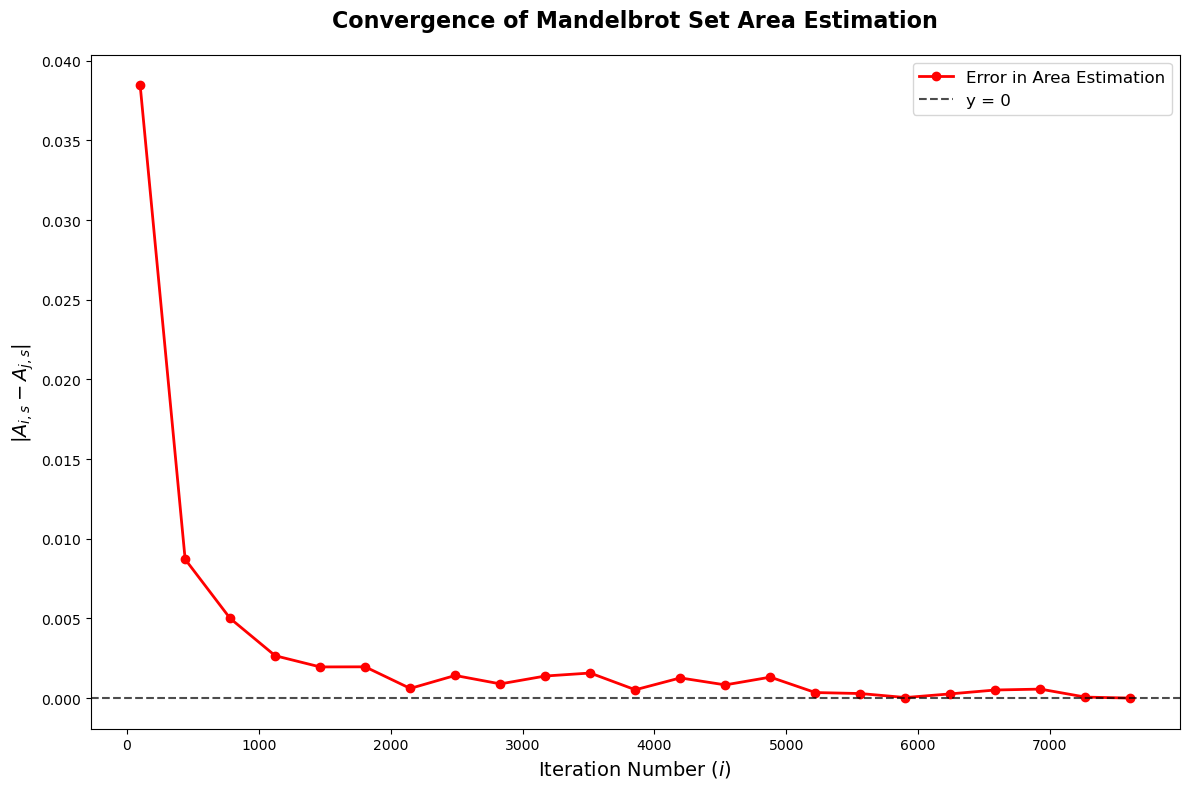

In [76]:
print(area)
plot_converge(area, iters_list[:len(area)])